In [1]:
import random
import numpy as np

SEED = 93
np.random.seed(SEED)
random.seed(SEED)

In [2]:
import torch

if torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score


def compute_accuracy(eval_pred):
    predictions_score, labels = eval_pred
    predictions_score = np.exp(predictions_score)
    denom = np.sum(predictions_score, axis=1)
    predictions_score = predictions_score / denom[:, np.newaxis]
    predictions = np.argmax(predictions_score, axis=1)
    balanced = balanced_accuracy_score(y_true=labels, y_pred=predictions)
    roc_auc = roc_auc_score(labels, predictions_score, multi_class="ovr", average="macro")
    kappa = cohen_kappa_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    return {"balanced_accuracy": balanced, "roc_auc": roc_auc, "kappa": kappa, "f1": f1}

In [4]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {i: "{id} Star" for i in range(5)}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
).to(device)

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [5]:
model.base_model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [6]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [7]:
from datasets import load_dataset

data_dict = {
    "train": "yelp_train_unbalanced.parquet",
    "eval": "yelp_eval.parquet",
    "test": "yelp_test.parquet"
}

yelp_ubtrain_data = load_dataset("parquet", data_files=data_dict, split="train")
yelp_eval_data = load_dataset("parquet", data_files=data_dict, split="eval")
yelp_ubtrain_data

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 700269
})

In [8]:
from transformers import DataCollatorWithPadding, AutoTokenizer

BATCH_TRAIN = 128
BATCH_EVAL = 256
GRADIENT_STEP = 1
LEARNING_RATE = 1e-4
EPOCHS = 4
LAMBDA = 0.01

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="yelp-distil-bert-unb",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRADIENT_STEP,
    gradient_checkpointing=False,
    num_train_epochs=EPOCHS,
    weight_decay=LAMBDA,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=yelp_ubtrain_data,
    eval_dataset=yelp_eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_accuracy
)

try:
    results = trainer.train(resume_from_checkpoint = True)
except ValueError:
    results = trainer.train(resume_from_checkpoint = False)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


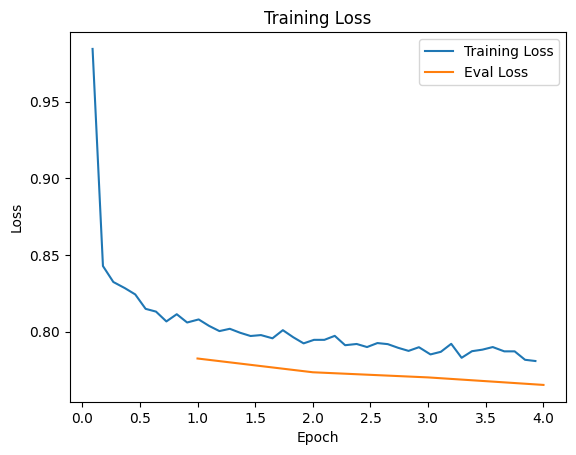

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

training_df = pd.DataFrame(trainer.state.log_history)[["epoch", "loss", "eval_loss"]]
train_x = training_df["epoch"].loc[~training_df.loss.isna()]
train_y = training_df["loss"].dropna()
eval_x = training_df["epoch"].loc[~training_df.eval_loss.isna()]
eval_y = training_df["eval_loss"].dropna()
plt.plot(train_x, train_y, label="Training Loss")
plt.plot(eval_x, eval_y, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.show()

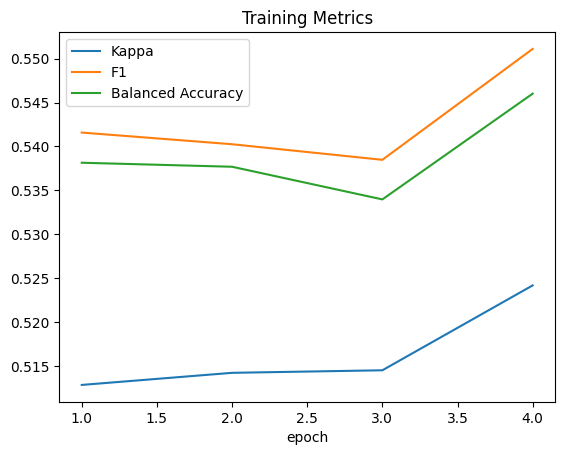

In [10]:
metric_df = pd.DataFrame(trainer.state.log_history)[["epoch", "eval_kappa", 
                                                     "eval_f1", "eval_balanced_accuracy"]]
metric_df = metric_df.rename(columns={"eval_kappa": "Kappa", 
                          "eval_f1": "F1", "eval_balanced_accuracy": 
                          "Balanced Accuracy"})
metric_df.dropna().set_index("epoch").plot()
plt.title("Training Metrics")
plt.show()

In [ ]:
model.eval()


def inference(text_batch):
    tokenized = tokenizer(text_batch, padding=True, truncation=True, return_tensors="pt").to(device)
    return model(**tokenized)


yelp_test = load_dataset("parquet", data_files=data_dict, split="test").remove_columns(['input_ids', 'attention_mask'])
yelp_test = yelp_test.map(lambda d: {"predicted_scores": inference(d["text"]).logits}, 
                          batched=True, batch_size=BATCH_EVAL)
yelp_test = yelp_test.map(lambda d: {"predicted": np.argmax(d["predicted_scores"], axis=1)}, 
                          batched=True, batch_size=BATCH_EVAL)
yelp_test

Map:   0%|          | 0/150058 [00:00<?, ? examples/s]

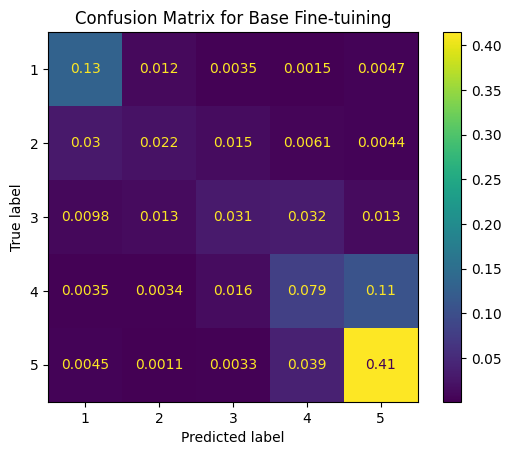

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=yelp_test["label"], 
                                        y_pred=yelp_test["predicted"], 
                                        display_labels=list(range(1, 6)), 
                                        normalize="all"
                                       )
plt.title("Confusion Matrix for Base Fine-tuining")
plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_true=yelp_test["label"], 
                            y_pred=yelp_test["predicted"], 
                            target_names=["%d Star" % i for i in range(1, 6)]))

              precision    recall  f1-score   support

      1 Star       0.73      0.86      0.79     22971
      2 Star       0.42      0.29      0.34     11561
      3 Star       0.46      0.31      0.37     14764
      4 Star       0.50      0.38      0.43     31283
      5 Star       0.76      0.90      0.82     69479

    accuracy                           0.68    150058
   macro avg       0.58      0.55      0.55    150058
weighted avg       0.65      0.68      0.66    150058



In [18]:
compute_accuracy([yelp_test["predicted_scores"], yelp_test["label"]])

{'balanced_accuracy': 0.5460656392387634,
 'roc_auc': 0.8928247367260672,
 'kappa': 0.5241569854225914,
 'f1': 0.5515556804432981}

In [19]:
trainer.save_model()